# Fine-tune Stable Diffusion 1.5 model (general)

## Part 1 Install and import libraries

In [ ]:
!pip install -U datasets
!pip install -U peft
!pip install pytorch-ignite
!pip install tqdm

In [ ]:
# Huggingface libraries
from datasets import load_dataset
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import get_peft_model, PeftModel, LoraConfig, TaskType

# Pytorch libraries
import torch
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import DataLoader

# Metrics
from ignite.metrics import FID, InceptionScore

# Other libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

# Built-in libraries
import gc

## Part 2 Global variables

In [ ]:
# Base model
model_name = "runwayml/stable-diffusion-v1-5"

# Dataset for finetune
dataset_name = "jugg1024/pokemon-gpt4o-captions"

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

image_size = 256
batch_size = 4

In [ ]:
# Function for metrics calculation
# FID
def calculate_FID(real_images, generated_images):
    fid_metric = FID(device=device)
    fid_metric.update((real_images, generated_images))
    fid_score = fid_metric.compute()

    print(f"FID score: {fid_score}")
    return fid_score

# IS
def calculate_IS(generated_images):
    is_metric = InceptionScore(device=device)
    is_metric.update(generated_images)
    is_score = is_metric.compute()

    print(f"IS score: {is_score}")
    return is_score

In [ ]:
# Function for image generation
def generate_image_from_prompt(prompts,
                               pipeline,
                               num_inference_steps=50,
                               guidance_scale=7.5,
                               batch_size=1):
    if isinstance(prompts, str):
        prompts = [prompts]

    with torch.no_grad():
        result = pipeline(
            prompts,
            height=image_size,
            width=image_size,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=batch_size
        )

    return result.images

## Part 3 Load baseline model

In [ ]:
# Load baseline model
pipeline = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype = torch.float16,
    safety_checker = None,
    requires_safety_checker = False,
)
pipeline = pipeline.to(device)

unet = pipeline.unet
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
vae = pipeline.vae

## Part 4 Load dataset for general fine-tuning

In [ ]:
# Functions for preprocessing
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

def preprocess_train(data):
    text = tokenizer(data["en_text"],
                     padding="max_length",
                     truncation=True,
                     max_length=77,
                     return_tensors="pt"
    ).input_ids.squeeze(0)
    image = transform(data["image"])
    return {"text": text, "image": image}

def preprocess_test(data):
    text = data["en_text"]
    tokens = tokenizer(text).input_ids
    if len(tokens) > 75:
        truncated_tokens = tokens[:75]
        text = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
    image = transform(data["image"])
    return {"text": text, "image": image}

In [ ]:
# load general dataset
dataset = load_dataset(dataset_name, split="train")
train_test_split = dataset.train_test_split(test_size=0.05)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Apply preprocess
train_dataset = train_dataset.map(preprocess_train)
train_dataset.set_format(type="torch", columns=["text", "image"])

test_dataset = test_dataset.map(preprocess_test)
test_dataset.set_format(type="torch", columns=["text", "image"])

# Wrap with dataloader
train_dataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Part 5 Evaluate baseline model

  0%|          | 0/50 [00:00<?, ?it/s]

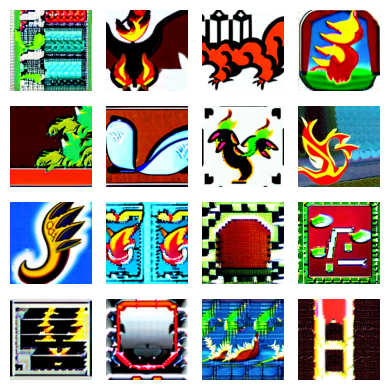

In [ ]:
# Generare samples
gc.collect()
torch.cuda.empty_cache()

# set grid size and prompt
grid_size = 4
prompt = "a fire dragon pokemon"

# generate samples in batch
# if "cuda out of memory", you can generate one by one
generated_images = generate_image_from_prompt(prompt,
                                              pipeline,
                                              batch_size=grid_size**2)


# visualize sample images
plt.figure(figsize=(grid_size, grid_size))
for i in range(len(generated_images)):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate FID and IS
gc.collect()
torch.cuda.empty_cache()

# Generate images in batch, require large cuda memory
prompts = test_dataset["text"]
generated_images = generate_image_from_prompt(prompts, pipeline)

# Generate image one by one
#generated_images = []
#for prompt in tqdm(test_dataset["text"]):
#    generated_image = generate_image_from_prompt(prompt, pipeline)
#    generated_images.append(generated_image)

real_images = [torch.tensor(image) for image in test_dataset["image"]]
generated_images = [transform(image) for image in generated_images]

# Calculate FID and IS
real_images = torch.stack(real_images).to(device)
generated_images = torch.stack(generated_images).to(device)

fid_score = calculate_FID(real_images, generated_images)
is_score = calculate_IS(generated_images)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Part 6 Fine-tune model

In [ ]:
# Freeze gradients
text_encoder.requires_grad_(False)
vae.requires_grad_(False)

# Apply lora to unet
lora_config = LoraConfig(
    r = 8,
    lora_alpha = 16,
    target_modules = ["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout = 0.1,
    bias = "none",
)

unet = get_peft_model(unet, lora_config)
unet.enable_gradient_checkpointing()

# noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

# Optimizer
optimizer = AdamW(unet.parameters(),
                  lr = 1e-4,
                  weight_decay = 1e-4,
                  eps = 1e-8
)

In [ ]:
# Train model
epochs = 4
total_steps = 0
gradient_accumulation_steps = 4

unet.train()
for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_dataLoader, desc=f"Epoch {epoch+1}/{epochs}")

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        images = batch["image"].to(device, dtype=torch.float16)
        tokens = batch["text"].to(device)

        # Encode tokens and images
        text_embeddings = text_encoder(tokens)[0]  # Shape: [batch, seq_len, 768]

        latents = vae.encode(images).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        # Sample noise and timesteps
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                 (latents.shape[0],), device=device).long()

        # Add noise to latents
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise (SD 1.5 simple format)
        noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        loss = loss / gradient_accumulation_steps

        # Backward pass
        loss.backward()

        epoch_loss += loss.item()

        # Update weights every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            total_steps += 1

        # Update progress bar
        progress_bar.set_postfix({
            "loss": f"{loss.item() * gradient_accumulation_steps:.4f}",
            "avg_loss": f"{epoch_loss / (step + 1) * gradient_accumulation_steps:.4f}"
        })

        # Memory cleanup every 50 steps
        if step % 50 == 0:
            torch.cuda.empty_cache()

    print(f"Epoch {epoch+1} completed. Average loss: {epoch_loss / len(train_dataLoader) * gradient_accumulation_steps:.4f}")

Epoch 1/4: 100%|██████████| 198/198 [01:30<00:00,  2.19it/s, loss=0.1013, avg_loss=0.0991]


Epoch 1 completed. Average loss: 0.0991


Epoch 2/4: 100%|██████████| 198/198 [01:29<00:00,  2.21it/s, loss=0.1125, avg_loss=0.0850]


Epoch 2 completed. Average loss: 0.0850


Epoch 3/4: 100%|██████████| 198/198 [01:29<00:00,  2.21it/s, loss=0.0997, avg_loss=0.0780]


Epoch 3 completed. Average loss: 0.0780


Epoch 4/4: 100%|██████████| 198/198 [01:29<00:00,  2.22it/s, loss=0.0858, avg_loss=0.0796]

Epoch 4 completed. Average loss: 0.0796


## Part 7 Evaluate fine-tuned model

  0%|          | 0/50 [00:00<?, ?it/s]

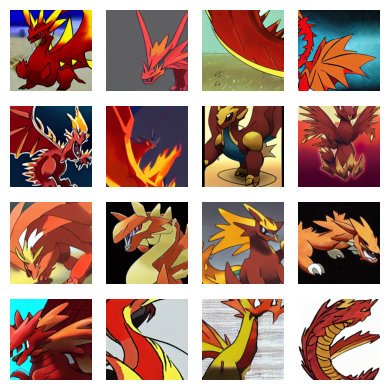

In [ ]:
# Generare samples
gc.collect()
torch.cuda.empty_cache()

# set grid size and prompt
grid_size = 4
prompt = "a fire dragon pokemon"

# generate samples in batch
# if "cuda out of memory", you can generate one by one
generated_images = generate_image_from_prompt(prompt,
                                              pipeline,
                                              batch_size=grid_size**2)

# visualize sample images
plt.figure(figsize=(grid_size, grid_size))
for i in range(len(generated_images)):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate FID and IS
gc.collect()
torch.cuda.empty_cache()

# Generate images in batch, require large cuda memory
prompts = test_dataset["text"]
generated_images = generate_image_from_prompt(prompts, pipeline)

# Generate image one by one
#generated_images = []
#for prompt in tqdm(test_dataset["text"]):
#    generated_image = generate_image_from_prompt(prompt, pipeline)
#    generated_images.append(generated_image)

real_images = [torch.tensor(image) for image in test_dataset["image"]]
generated_images = [transform(image) for image in generated_images]

# Calculate FID and IS
real_images = torch.stack(real_images).to(device)
generated_images = torch.stack(generated_images).to(device)

fid_score = calculate_FID(real_images, generated_images)
is_score = calculate_IS(generated_images)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-15-1456677a24b5>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_images = [torch.tensor(image) for image in test_dataset["image"]]


FID score: 0.43194353870708885
IS score: 11.356870843917818


In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Save fine-tuned model

In [ ]:
# Save unet lora for general pokemon generation
unet.save_pretrained("unet_lora_general")

In [ ]:
# Zip file
!zip -r unet_lora_general.zip unet_lora_general

  adding: unet_lora_general/ (stored 0%)
  adding: unet_lora_general/adapter_model.safetensors (deflated 7%)
  adding: unet_lora_general/adapter_config.json (deflated 55%)
  adding: unet_lora_general/README.md (deflated 65%)
